In [1]:
import h5py
import io
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import skimage

from lsd.train import local_shape_descriptor
from scipy.ndimage import median_filter
from skimage.filters import sobel, threshold_li
from skimage.measure import label
from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.segmentation import watershed

%matplotlib inline

## 2d Examples

* Labels in coins example generated following this [tutorial](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_expand_labels.html)

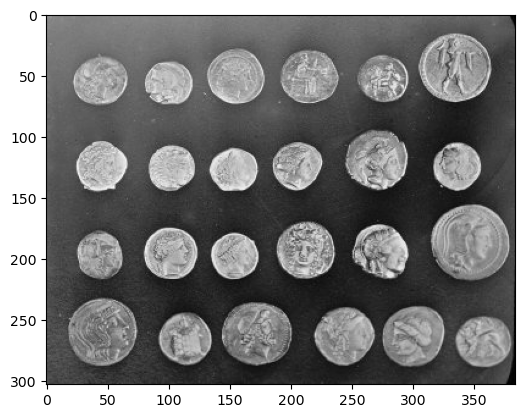

In [2]:
# get coins dataset
data = skimage.data.coins()

plt.imshow(data, cmap='gray')

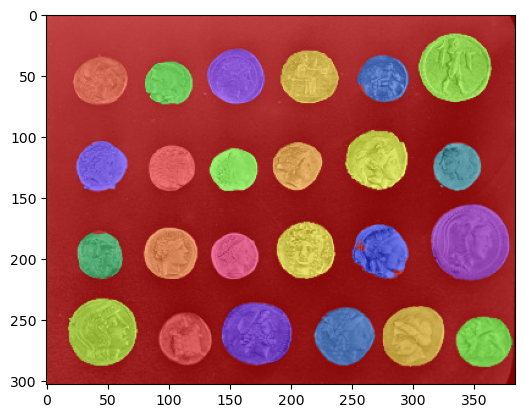

In [3]:
# create edges
edges = sobel(data)

# generate markers for watershed
markers = np.zeros_like(data)
foreground, background = 1, 2
markers[data < 30.0] = background
markers[data > 150.0] = foreground

# get unique labels
ws = watershed(edges, markers)
labels = label(ws == foreground).astype(np.uint64)

plt.imshow(data, cmap='gray')
plt.imshow(labels, cmap='prism', alpha=0.5)

In [4]:
# calculate lsds
lsds = local_shape_descriptor.get_local_shape_descriptors(
              segmentation=labels,
              sigma=(15,)*2,
              voxel_size=(1,)*2)

# 6 channels for 2d
print(lsds.shape)

(6, 303, 384)


In [5]:
def view_lsds(lsds):

  fig, axes = plt.subplots(
            2,
            3,
            figsize=(25, 10),
            sharex=True,
            sharey=True,
            squeeze=False)
  
  axes[0][0].imshow(np.squeeze(lsds[0]), cmap='jet')
  axes[0][0].title.set_text('Mean offset Y')

  axes[0][1].imshow(np.squeeze(lsds[1]), cmap='jet')
  axes[0][1].title.set_text('Mean offset X')

  axes[0][2].imshow(np.squeeze(lsds[2]), cmap='jet')
  axes[0][2].title.set_text('Covariance Y-Y')

  axes[1][0].imshow(np.squeeze(lsds[3]), cmap='jet')
  axes[1][0].title.set_text('Covariance X-X')

  axes[1][1].imshow(np.squeeze(lsds[4]), cmap='jet')
  axes[1][1].title.set_text('Covariance Y-X')

  axes[1][2].imshow(np.squeeze(lsds[5]), cmap='jet')
  axes[1][2].title.set_text('Size')

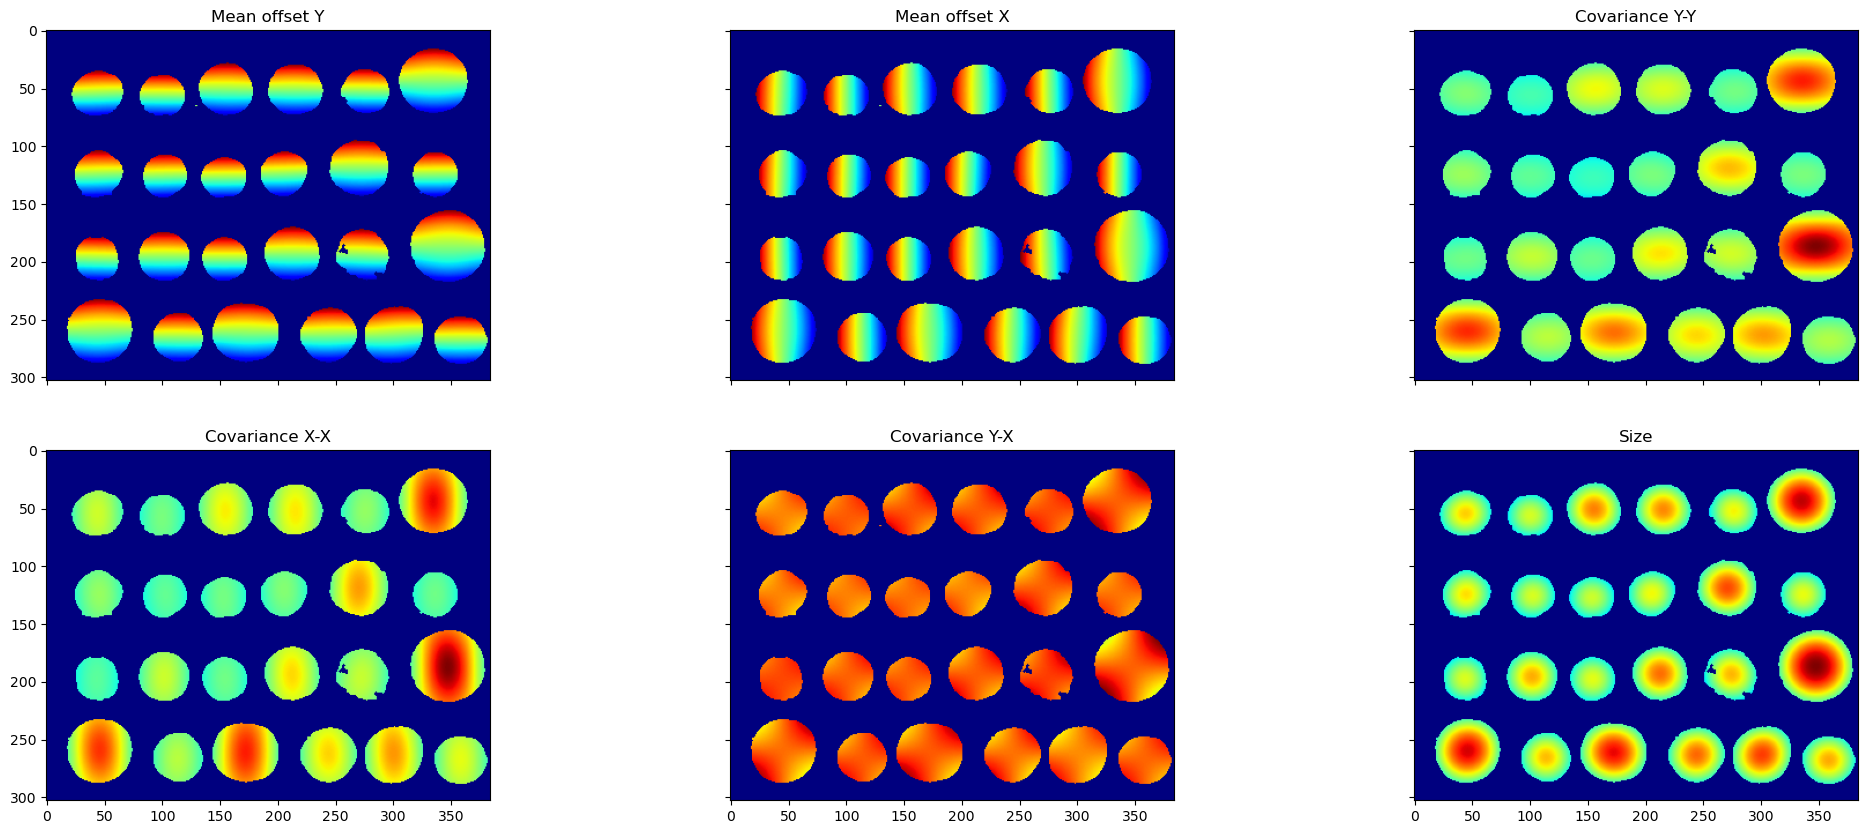

In [8]:
view_lsds(lsds)

In [6]:
# example data from cremi challenge - might take a couple seconds to download
url = 'https://cremi.org/static/data/sample_A_20160501.hdf'

# convert from binary
container = h5py.File(io.BytesIO(requests.get(url).content), 'r')

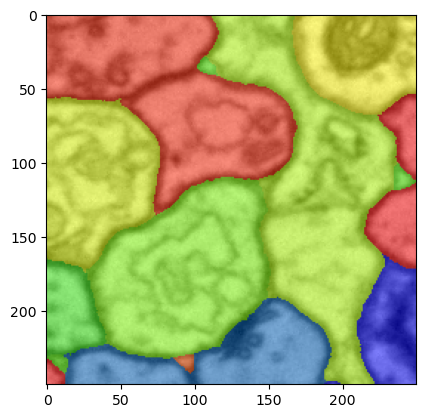

In [7]:
# get corner patch
raw = np.squeeze(container['volumes/raw'][0:1,0:250,0:250])
labels = np.squeeze(container['volumes/labels/neuron_ids'][0:1,0:250,0:250])

plt.imshow(raw, cmap='gray')
plt.imshow(labels, cmap='prism', alpha=0.5)

In [8]:
# calc lsds
lsds = local_shape_descriptor.get_local_shape_descriptors(
              segmentation=labels,
              sigma=(100,)*2,
              voxel_size=[4,4])

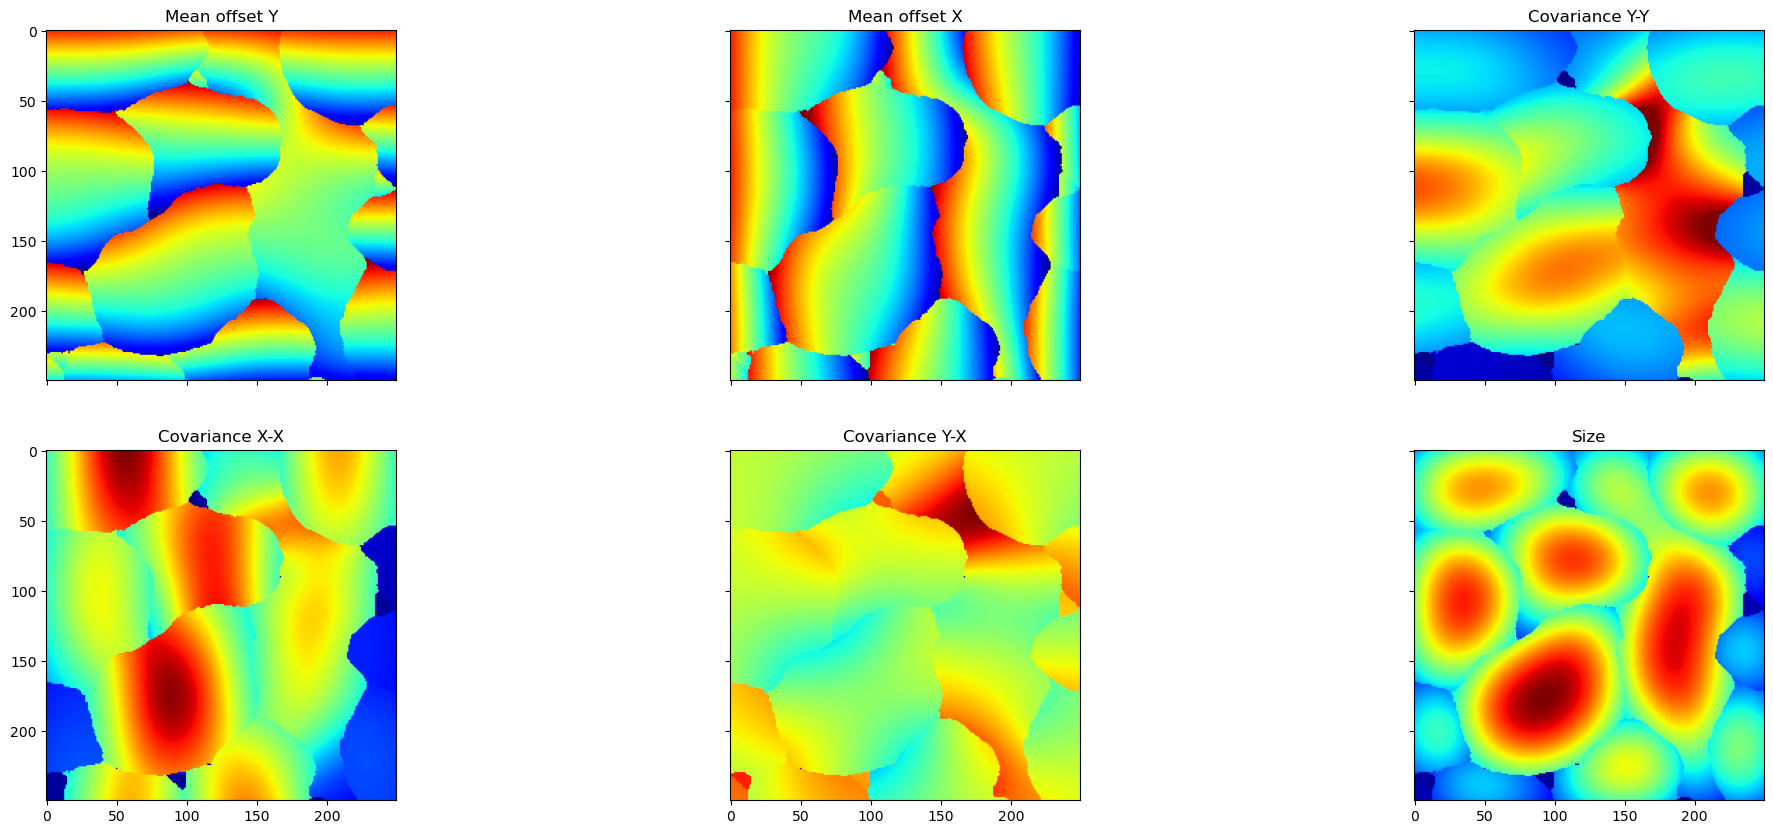

In [13]:
view_lsds(lsds)

## 3d example

* Labels created following the start of this [tutorial](https://jni.github.io/i2k-skimage-napari/lectures/2_segmentation_and_regionprops.html)
* There will be some falsely merged labels, but this should be a good starting point to see 3d lsds


In [9]:
# get 3d cells data, use nuceli channel
data = skimage.data.cells3d()[:, 1]

# ignore end sections that don't contain cells
data = data[25:45]

# denoise
denoised = median_filter(data, size=3)

In [22]:
from ipywidgets import interact
import ipywidgets as widgets



def plot_3d(img):
    depth = img.shape[0]

    def plot_section(z):
        plt.figure()
        plt.imshow(img[int(z)])
        plt.show()

    interact(plot_section, z=widgets.FloatSlider(value=depth // 2, min=0, max=depth-1, step=1))

plot_3d(denoised)

interactive(children=(FloatSlider(value=10.0, description='z', max=19.0, step=1.0), Output()), _dom_classes=('…

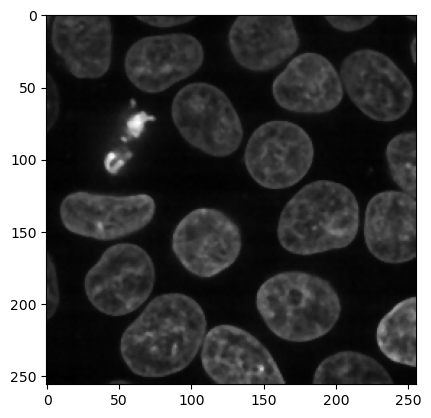

In [23]:
plt.imshow(denoised[10], cmap='gray')

In [24]:
# create binary mask
thresholded = denoised > threshold_li(denoised)

# remove small holes and objects
remove_holes = remove_small_holes(thresholded, 20**3)
remove_objects = remove_small_objects(remove_holes, 20**3)

# relabel connected components
labels = label(remove_objects).astype(np.uint64)

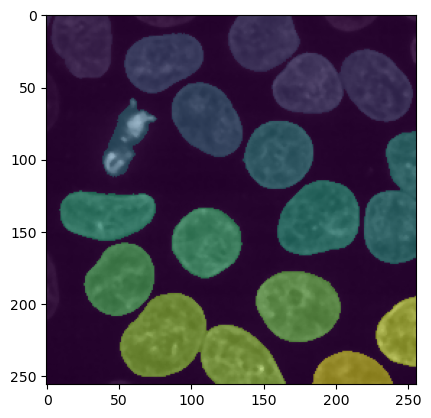

In [25]:
plt.imshow(denoised[10], cmap='gray')
plt.imshow(labels[10], alpha=0.5)

In [26]:
# take a random crop for efficiency
def random_crop(labels, crop_size):
    y = random.randint(0, labels.shape[1] - crop_size)
    x = random.randint(0, labels.shape[2] - crop_size)
    labels = labels[:, y:y+crop_size, x:x+crop_size]
    return labels

In [27]:
# calculate lsds
lsds = local_shape_descriptor.get_local_shape_descriptors(
                segmentation=random_crop(labels, 100),
                sigma=(5,) * 3,
                voxel_size=(1,) * 3)

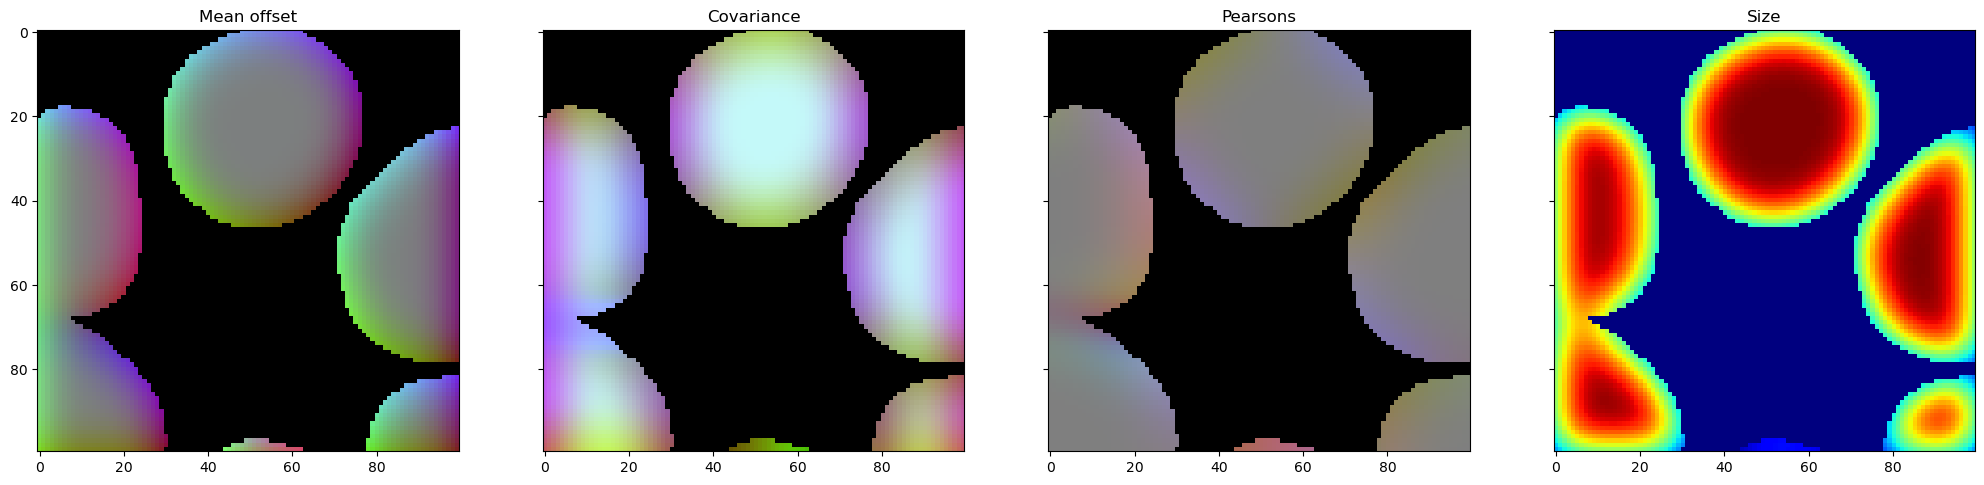

In [28]:
# view lsds (example section 10)
fig, axes = plt.subplots(
            1,
            4,
            figsize=(25, 10),
            sharex=True,
            sharey=True,
            squeeze=False)

# lsds are shape: c,z,y,x (where channels is now 10 dimensions)
# first 3 components can be rendered as rgb, matplotlib expects channels last
axes[0][0].imshow(lsds[0:3,10].T)
axes[0][0].title.set_text('Mean offset')

axes[0][1].imshow(lsds[3:6,10].T)
axes[0][1].title.set_text('Covariance')

axes[0][2].imshow(lsds[6:9,10].T)
axes[0][2].title.set_text('Pearsons')

axes[0][3].imshow(lsds[9,10].T, cmap='jet')
axes[0][3].title.set_text('Size')